# MGT 595 Problem Set 3
# Student: Joseph Weintraub
# September 23, 2024

In [708]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

#### Data Cleaning and Preprocessing

In [709]:
xls = pd.ExcelFile("/Users/josephweintraub/Downloads/Problem_Set3_2024.xls")
market_proxy_df = pd.read_excel(xls, 'Market_proxy', skiprows=5)
size_BEME_portfolios_df = pd.read_excel(xls, '25_Size_BEME_Portfolios', skiprows=1)
industry_portfolios_df = pd.read_excel(xls, '49_Industry_Portfolios', skiprows=6, nrows=1085)

In [710]:
df_value_weighted = industry_portfolios_df.iloc[:, :50]
df_firm_size = industry_portfolios_df.iloc[:, 51:101]
df_BEME_annual = industry_portfolios_df.iloc[:, 102:152]

In [711]:
def set_indexes_monthly(df):
    df.set_index(df.columns[0], inplace=True)
    df.index = pd.to_datetime(df.index, format='%Y%m')

    return df

df_value_weighted = set_indexes(df_value_weighted)
df_firm_size = set_indexes(df_firm_size)
df_firm_size = df_firm_size.rename(columns=lambda col: col.split('.')[0])
market_proxy_df = set_indexes(market_proxy_df)

df_BEME_annual.set_index('Unnamed: 102', inplace=True)
df_BEME_annual.index = pd.to_datetime(df_BEME_annual.index, format="%Y")
df_BEME_annual = df_BEME_annual.iloc[:91]
df_BEME_monthly = df_BEME_annual.loc[df_BEME_annual.index.repeat(12)].reset_index(drop=True)
df_BEME_monthly = df_BEME_monthly.iloc[7:1092]
df_BEME_monthly = df_BEME_monthly.rename(columns=lambda col: col.split('.')[0])
df_BEME_monthly.reset_index(inplace=True, drop=True)
df_BEME_monthly.index = df_value_weighted.index

#### Post-Processing Data Validation

In [712]:
df_value_weighted.head(5)

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1926-07-01,2.37,0.12,-99.99,-5.19,1.29,8.65,2.50,50.21,-0.48,8.08,...,7.70,1.94,-23.79,0.07,1.87,4.61,-0.54,2.89,-4.85,5.20
1926-08-01,2.23,2.68,-99.99,27.03,6.50,16.81,-0.76,42.98,-3.58,-2.51,...,-2.38,4.88,5.39,-0.75,-0.13,11.83,2.57,5.30,-0.57,6.76
1926-09-01,-0.57,1.58,-99.99,4.02,1.26,8.33,6.42,-4.91,0.73,-0.51,...,-5.54,0.06,-7.87,0.25,-0.56,-1.75,0.72,-3.06,-3.14,-3.86
1926-10-01,-0.46,-3.68,-99.99,-3.31,1.06,-1.40,-5.09,5.37,-4.68,0.12,...,-5.08,-2.64,-15.38,-2.20,-4.11,-11.82,-4.28,-5.74,2.07,-8.49
1926-11-01,6.75,6.26,-99.99,7.29,4.55,0.00,1.82,-6.40,-0.54,1.87,...,3.84,1.60,4.67,6.52,4.33,-2.97,3.58,2.21,4.92,4.00


In [713]:
df_firm_size.head(5)

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Unnamed: 51,,,,,,,,,,,,,,,,,,,,,
1926-07-01,99.80,31.19,-99.99,7.12,59.72,13.00,28.64,4.33,22.27,18.36,...,35.35,68.67,1.19,46.65,10.82,14.50,31.82,22.92,10.28,24.25
1926-08-01,102.06,31.15,-99.99,6.75,60.47,14.12,29.34,6.50,22.13,19.83,...,37.86,69.79,0.90,46.57,11.00,15.17,31.65,23.56,9.76,25.51
1926-09-01,104.34,31.95,-99.99,8.58,64.03,16.50,29.10,9.29,21.18,19.29,...,36.82,72.90,0.95,46.11,10.94,16.97,32.46,24.47,9.70,27.21
1926-10-01,102.91,32.21,-99.99,8.92,64.42,17.88,30.58,8.83,21.23,19.03,...,34.77,72.71,0.88,46.15,10.80,16.46,32.66,23.72,9.39,26.16
1926-11-01,102.34,30.90,-99.99,8.62,65.08,17.62,29.01,9.31,20.14,19.03,...,32.80,70.58,0.74,45.03,10.33,14.52,31.26,22.33,9.56,23.94


In [714]:
df_BEME_monthly.head(5)

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1926-07-01,0.65,0.63,-99.99,2.54,0.79,1.99,0.81,4.34,0.38,0.9,...,0.97,1.41,2.35,0.44,0.66,0.66,0.62,0.88,0.98,0.63
1926-08-01,0.65,0.63,-99.99,2.54,0.79,1.99,0.81,4.34,0.38,0.9,...,0.97,1.41,2.35,0.44,0.66,0.66,0.62,0.88,0.98,0.63
1926-09-01,0.65,0.63,-99.99,2.54,0.79,1.99,0.81,4.34,0.38,0.9,...,0.97,1.41,2.35,0.44,0.66,0.66,0.62,0.88,0.98,0.63
1926-10-01,0.65,0.63,-99.99,2.54,0.79,1.99,0.81,4.34,0.38,0.9,...,0.97,1.41,2.35,0.44,0.66,0.66,0.62,0.88,0.98,0.63
1926-11-01,0.65,0.63,-99.99,2.54,0.79,1.99,0.81,4.34,0.38,0.9,...,0.97,1.41,2.35,0.44,0.66,0.66,0.62,0.88,0.98,0.63


In [715]:
market_proxy_df.head(5)

,Mkt-RF,RF
Unnamed: 0,,
1926-07-01,2.96,0.22
1926-08-01,2.64,0.25
1926-09-01,0.36,0.23
1926-10-01,-3.24,0.32
1926-11-01,2.53,0.31


# Part 1: 49 Industry Portfolio

*a) Considerthe cross-sectional regression, where γ0 and γM are regression parameters and βiM = cov(Ri, RM)/σ2(RM). If the CAPM holds, then what should γ0 and γM equal (for both the Sharpe/Lintner and Black versions)?*

##### <div align="center"> Ri = γ0 + γM βiM + ηi </div> 

For the Sharpe-Lintner model, $\gamma_0$ should be equal to the risk-free rate, and $\gamma_M$ should be equal to the market risk premium for specific risky asset i. In the Black model of the CAPM, γ0 should be equal to the return on the zero-beta portfolio, and γM should be equal to the excess return of the market over the zero-beta portfolio.


#### Estimate $\gamma_0$ and $\gamma_M$ using the approach pioneered by Fama and MacBeth. 

In [716]:
def betas_regressions_part_b(df):
    betas = {}
    
    for portfolio in df.columns:    
        mask = (df[portfolio] == -99.99) | (df[portfolio] == -999)
        df_1 = df[~mask] - market_proxy_df['RF'].mean()
        df_2 = market_proxy_df[~mask]['Mkt-RF']
        X = sm.add_constant(df_2)
        model = sm.OLS(df_1[portfolio], X)
        results = model.fit()
        betas[portfolio] = results.params.iloc[1]
        
    gamma_0 = []
    gamma_1 = []

    for t in range(len(df)):
        mask = (df.iloc[t] == -99.99) | (df.iloc[t] == -999)
        valid_returns = df.iloc[t][~mask] - market_proxy_df.iloc[t]['RF']
        betas_valid = pd.Series(betas)[~mask]
    
        X = sm.add_constant(betas_valid)
        model = sm.OLS(valid_returns, X)
        results = model.fit()
    
        gamma_0.append(results.params.iloc[0])
        gamma_1.append(results.params.iloc[1])

    gamma_0 = np.array(gamma_0)
    gamma_1 = np.array(gamma_1)

    gamma_0_mean = np.mean(gamma_0)
    gamma_1_mean = np.mean(gamma_1)

    gamma_0_se = np.std(gamma_0) / np.sqrt(len(gamma_0))
    gamma_1_se = np.std(gamma_1) / np.sqrt(len(gamma_1))

    gamma_0_tstat = gamma_0_mean / gamma_0_se
    gamma_1_tstat = gamma_1_mean / gamma_1_se
    
        
    print(f"Gamma 0 (mean): {gamma_0_mean}, SE: {gamma_0_se}, t-stat: {gamma_0_tstat}")
    print(f"Gamma M (mean): {gamma_1_mean}, SE: {gamma_1_se}, t-stat: {gamma_1_tstat}")

In [717]:
print("\n-------------------------------------------------------------------------------------------------\n")
betas_regressions_part_b(df_value_weighted) 
print("\n-------------------------------------------------------------------------------------------------\n")


-------------------------------------------------------------------------------------------------

Gamma 0 (mean): 0.529514374455567, SE: 0.1873001982105955, t-stat: 2.8270892370343077
Gamma M (mean): 0.22156635565958155, SE: 0.2525511140473766, t-stat: 0.8773129213677411

-------------------------------------------------------------------------------------------------



Yes we can reject the hypothesis that the proxy for the market portfolio is mean-variance efficient. This conclusion is based off of the fact that: 
- $\gamma_0$ is significantly different from 0 suggesting that there is an unexplained component of returns, which violates the condition for mean-variance efficiency.
- γM (beta) is not significantly differently from 0 given a t-stat of 0.858, which is small and not statistically significant. Thus, indicating that the market proxy does not explain the returns of the portfolios well. This discovery is what earned the paper the title “the death of beta.” 


#### c)	Estimate the cross-sectional regression, ave(Ri) = $\gamma_0$ + $\gamma_M$ $\beta_{i,M}$ + $\eta_i$.  Are the estimates of $\gamma_0$ and $\gamma_M$ different than the average estimates in part b?  Are the standard errors of the estimates of γ0 and γM different than the standard errors of the average estimates in part b? Why or why not? Which method is superior? Why?

In [718]:
def betas_regressions_part_c(df, market_proxy_df):
    betas = {}
    average_returns = {}
    
    for portfolio in df.columns:    
        mask = (df[portfolio] == -99.99) | (df[portfolio] == -999)
        df_1 = df[~mask] - market_proxy_df['RF'].mean()
        df_2 = market_proxy_df[~mask]['Mkt-RF']
        X = sm.add_constant(df_2)
        model = sm.OLS(df_1[portfolio], X)
        results = model.fit()
        betas[portfolio] = results.params.iloc[1]
        average_returns[portfolio] = df_1[portfolio].mean()

    betas_df = pd.Series(betas)
    returns_df = pd.Series(average_returns)

    X = sm.add_constant(betas_df)
    model = sm.OLS(returns_df, X)
    results = model.fit()
    
    gamma_0 = results.params.iloc[0]
    gamma_1 = results.params.iloc[1]
    gamma_0_se = results.bse.iloc[0]
    gamma_1_se = results.bse.iloc[1]
    gamma_0_tstat = (gamma_0 - market_proxy_df['RF'].mean()) / gamma_0_se
    gamma_1_tstat = gamma_1 / gamma_1_se

    print(f"Cross-Sectional Regression Results:")
    print(f"Gamma 0 (Intercept): {gamma_0}, SE: {gamma_0_se}, t-stat: {gamma_0_tstat}")
    print(f"Gamma M (Slope): {gamma_1}, SE: {gamma_1_se}, t-stat: {gamma_1_tstat}")

    return betas_df, returns_df


In [719]:
print("\n-------------------------------------------------------------------------------------------------\n")
betas_df, returns_df = betas_regressions_part_c(df_value_weighted, market_proxy_df)
print("\n-------------------------------------------------------------------------------------------------\n")


-------------------------------------------------------------------------------------------------

Cross-Sectional Regression Results:
Gamma 0 (Intercept): 0.6297868146178601, SE: 0.0927301709984721, t-stat: 3.79306445023686
Gamma M (Slope): 0.12343422237991512, SE: 0.08462883862540303, t-stat: 1.4585361725957076

-------------------------------------------------------------------------------------------------



The estimates are slightly different, and that is expected, as returns will exhibit variability over time, thus the estimate of the second approach skips the time dimension of the problem. 

The standard errors of part b) are slightly greater than the ones from part c) and that is explained by the fact that the standard errors reflect the variability across time periods, and in part c) they are only reflecting the cross-section variation across portfolios. Thus, volatility over time is more prevalent.

If returns are relatively stable across time, both approaches are perfectly acceptable, but to capture the variance over time, the Fama and MacBeth approach is more robust as it captures both time variance and cross sectional variance.


#### d)	Plot the ave($R_i$) for the portfolios against their $\beta_{i,M}$.  Does the plot resemble a positive relationship?  What should the plot look like?

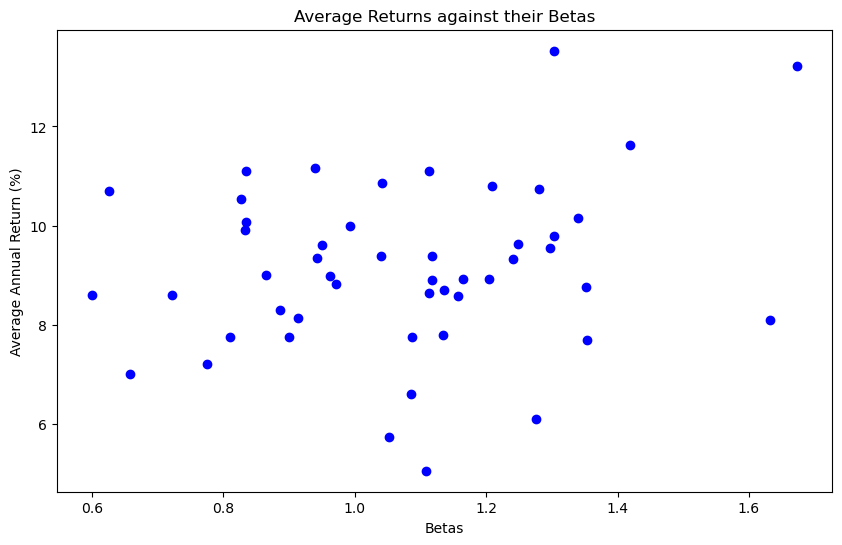

In [720]:
plt.figure(figsize=(10,6))
plt.scatter(betas_df, returns_df * 12, color="blue")
plt.xlabel("Betas")
plt.ylabel("Average Annual Return (%)")
plt.title("Average Returns against their Betas")
plt.show()

The plot should look like a clear positive relationship between betas and average annual returns. This would be because by the CAPM’s assumptions beta is meant to explain all excess returns, however the plot makes it evident that that is not the case. The scatter plot that we plotted seems to suggest that there is no relationship between betas and average annual return, which points at the idea that there are other factors that explain stock returns better, and beta is a very very poor predictor. 

#### *e)	Now, consider the cross-sectional regression, where $\gamma_0$, $\gamma_M$, $\gamma_{size}$, and $\gamma_{B/M}$ are regression parameters, $i_M$ = $\frac{cov(R_i, R_M)}{\sigma_2(R_M)}$, and size and BE/ME are the average size and  book to market ratio of the portfolio.* 
<div align="center"> (2) Ri = $\gamma_0$ + $\gamma_M$ $\beta_{i,M}$ + $\gamma_{size}$ $\ln{(size)}$  + $\gamma_{B/M}$ $\ln{(BE/ME)}$ + $\eta_i$ </div>

#### *If the CAPM holds, then what should $\gamma_{size}$ and $\gamma_{B/M}$ equal?*

If the CAPM holds then $\gamma_{size}$ and $\gamma_{B/M}$ should equal 0, because theoretically beta should fully predict an asset’s returns.

#### Estimate $\gamma_0$, $\gamma_M$, $\gamma_{size}$, and $\gamma_{B/M}$ using the Fama MacBeth procedure. 

*Why is it important that the size and BE/ME characteristics should be lagged values?*

Lagging values ensures that we are not using future information to explain current returns. In practice, investors can only use data that is available to them at the time, so by lagging by a month, we are giving ourselves a month for that data to have become available. Furthermore, if we do not lag our data, then it is very likely that our results will appear to be much better than they should be, which is usually an alarming sign. 

In [721]:
def calculate_stats(data):
    mean = np.mean(data)
    std_err = np.std(data) / np.sqrt(len(data))
    t_stat = mean / std_err 
    return mean, std_err, t_stat

def betas_regressions_part_f(df_returns, df_size, df_BEME):
    # Step 1: Estimate betas for each portfolio
    betas = {}
    for portfolio in df_returns.columns:    
        mask = (df_returns[portfolio] == -99.99) | (df_returns[portfolio] == -999)
        df_1 = df_returns[~mask] - market_proxy_df['RF'].mean()
        df_2 = market_proxy_df[~mask]['Mkt-RF']
        X = sm.add_constant(df_2)
        model = sm.OLS(df_1[portfolio], X)
        results = model.fit()
        betas[portfolio] = results.params.iloc[1]
    
    # Step 2: Fama-MacBeth regression
    gamma_0, gamma_M, gamma_size, gamma_BEME = [], [], [], []
    
    for t in range(12, len(df_returns)):
        # Apply a single mask for returns, size, and BE/ME
        mask = (df_returns.iloc[t] < -99) | (df_size.iloc[t-1] < -99) | (df_BEME.iloc[t-12] < -99)
        valid_returns = df_returns.iloc[t][~mask] - market_proxy_df.iloc[t]['RF']
        betas_valid = pd.Series(betas)[~mask]
        valid_size = df_size.iloc[t-1][~mask]
        valid_BEME = df_BEME.iloc[t-12][~mask]
        
        X = pd.DataFrame({
            'beta': betas_valid,
            'ln_size': np.log(valid_size),
            'ln_BEME': np.log(valid_BEME)
        }).dropna()
        valid_returns = valid_returns.loc[X.index]
        
        X = sm.add_constant(X)
        model = sm.OLS(valid_returns, X)
        results = model.fit()
    
        gamma_0.append(results.params.iloc[0] - market_proxy_df['RF'].mean())
        gamma_M.append(results.params.iloc[1])
        gamma_size.append(results.params.iloc[2])
        gamma_BEME.append(results.params.iloc[3])

    # Step 3: Compute time series averages and statistics
    gammas = [gamma_0, gamma_M, gamma_size, gamma_BEME]
    gamma_names = ['gamma_0', 'gamma_M', 'gamma_size', 'gamma_BEME']

    data = []
    for gamma, name in zip(gammas, gamma_names):
        stats = calculate_stats(gamma)
        data.append([name] + list(stats))

    df = pd.DataFrame(data, columns=['Factor', 'Mean', 'Std Error', 't-stat'])
    return df

print("\n-------------------------------------------------------------------------------------------------\n")
print(betas_regressions_part_f(df_value_weighted, df_firm_size, df_BEME_monthly))
print("\n-------------------------------------------------------------------------------------------------\n")


-------------------------------------------------------------------------------------------------

       Factor      Mean  Std Error    t-stat
0     gamma_0  0.413818   0.304805  1.357651
1     gamma_M  0.060544   0.222415  0.272211
2  gamma_size -0.028735   0.040390 -0.711444
3  gamma_BEME  0.012569   0.074343  0.169064

-------------------------------------------------------------------------------------------------



##### Can you reject the hypothesis that the proxy for the market portfolio is mean variance efficient?

No we cannot reject the null hypothesis since the t-stat for $\gamma_0$ = 1.36 and $\gamma_M$ = .272 which is less than the critical value of 1.96, thus we fail to reject the null hypothesis.

# PART 2: 25 SIZE and BEME Portfolios

## 1) Repeat parts b), c), d), and f) for the 25 size and BE/ME portfolios instead of the industries.

In [722]:
sheet2_return = pd.read_excel(xls, sheet_name='25_Size_BEME_Portfolios', skiprows=2, index_col=None, usecols="A:Z", na_values=-99.99)
sheet2_return["Date"] = pd.to_datetime(sheet2_return["BE/ME"], format="%Y%m")
s2_return = sheet2_return.set_index("Date")
s2_return = s2_return.loc[s2_return.index.dropna()]
s2_return = s2_return.drop("BE/ME", axis = 1)
s2_return

sheet2_size = pd.read_excel(xls, sheet_name='25_Size_BEME_Portfolios', skiprows=2, index_col=None, usecols="AB:BA", na_values=-99.99)
sheet2_size["Date"] = pd.to_datetime(sheet2_size["BE/ME.1"], format="%Y%m")
s2_size = sheet2_size.set_index("Date")
s2_size = s2_size.loc[s2_size.index.dropna()]
s2_size = s2_size.drop("BE/ME.1", axis = 1)
s2_size.columns = s2_return.columns


sheet2_BEME = pd.read_excel(xls, sheet_name='25_Size_BEME_Portfolios', skiprows=2, index_col=None, usecols="BC:CB", na_values=-99.99)
sheet2_BEME["Date"] = pd.to_datetime(sheet2_BEME["BE/ME.2"], format="%Y")
s2_BEME = sheet2_BEME.set_index("Date")
s2_BEME = s2_BEME.loc[s2_BEME.index.dropna()]
s2_BEME = s2_BEME.drop("BE/ME.2", axis = 1)
s2_BEME.columns = s2_return.columns
s2_BEME_monthly = s2_BEME.loc[s2_BEME.index.repeat(12)].reset_index(drop=True)
s2_BEME_monthly = s2_BEME_monthly.iloc[7:1092]
s2_BEME_monthly = s2_BEME_monthly.reset_index(drop=True)

#### Repeated part b)

In [723]:
print("\n-------------------------------------------------------------------------------------------------\n")
betas_regressions_part_b(s2_return)
print("\n-------------------------------------------------------------------------------------------------\n")


-------------------------------------------------------------------------------------------------

Gamma 0 (mean): 0.3354251125165174, SE: 0.3278699478607142, t-stat: 1.0230431752135234
Gamma M (mean): 0.4557226810801412, SE: 0.35714768399104346, t-stat: 1.276006261576569

-------------------------------------------------------------------------------------------------



#### Repeated part c) and d)


-------------------------------------------------------------------------------------------------

Cross-Sectional Regression Results:
Gamma 0 (Intercept): 0.3354251125165175, SE: 0.3240131324423405, t-stat: 0.17706014736163883
Gamma M (Slope): 0.45572268108014097, SE: 0.26369612736290965, t-stat: 1.728211504801344

-------------------------------------------------------------------------------------------------



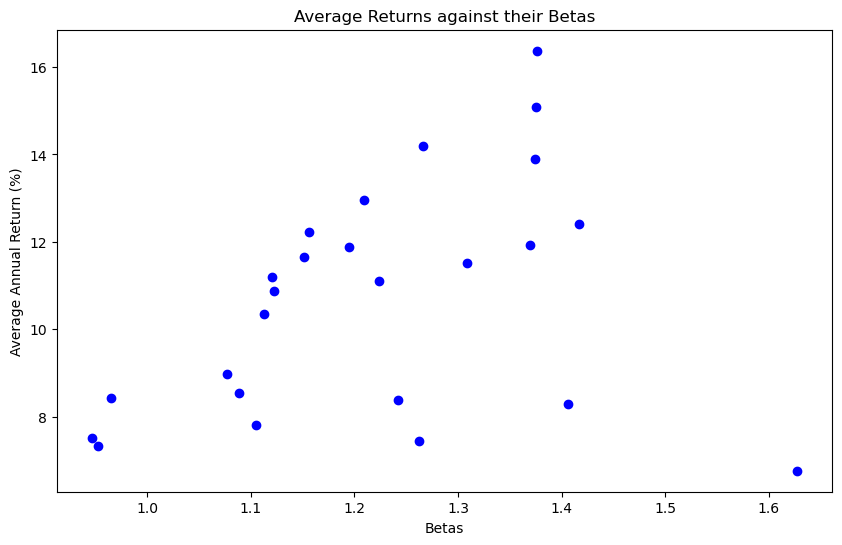

In [724]:
print("\n-------------------------------------------------------------------------------------------------\n")
betas_df, returns_df = betas_regressions_part_c(s2_return, market_proxy_df)
print("\n-------------------------------------------------------------------------------------------------\n")
plt.figure(figsize=(10,6))
plt.scatter(betas_df, returns_df * 12, color="blue")
plt.xlabel("Betas")
plt.ylabel("Average Annual Return (%)")
plt.title("Average Returns against their Betas")
plt.show()

#### Repeated part f)

In [725]:
print("\n-------------------------------------------------------------------------------------------------\n")
print(betas_regressions_part_f(s2_return, s2_size, s2_BEME_monthly))
print("\n-------------------------------------------------------------------------------------------------\n")


-------------------------------------------------------------------------------------------------

       Factor      Mean  Std Error    t-stat
0     gamma_0  1.654138   0.431169  3.836406
1     gamma_M -0.545124   0.370026 -1.473207
2  gamma_size -0.080250   0.031651 -2.535448
3  gamma_BEME  0.263321   0.060817  4.329724

-------------------------------------------------------------------------------------------------



#### 2) Repeat parts c) and d) for the 25 size and BE/ME portfolios 

We need to find the tangency portoflio of the 25 size and BE/ME portfolios instead of the market portfolio.

From class we know that to find the weights for each respective portfolio we can use the formula:

### <div align="center" height="20px"> $\frac{V^{-1}(R - r_f1)}{1' V^{-1} (R - r_f1)}$ </div>

And then reconstruct the returns for the tangency portfolio based on the weights to then recalculate betas.

In [726]:
s2_return_cov_matrix_inv = np.linalg.inv(s2_return.cov())
R = s2_return.mean()
rf = market_proxy_df['RF'].mean()
ones_array = np.transpose([1]*len(s2_return.columns))

In [727]:
numerator = s2_return_cov_matrix_inv @ (R - rf * ones_array)
denominator = np.transpose(ones_array) @ s2_return_cov_matrix_inv @ (R - rf * ones_array)

weights = numerator/denominator

Now we need to recalculate the returns with the given weights to create a new $R_M$ to then recalculate the betas.

In [728]:
new_returns = s2_return @ weights 
new_market_proxy_df = market_proxy_df.copy()
new_market_proxy_df['Mkt-RF'] = new_returns - market_proxy_df['RF']


-------------------------------------------------------------------------------------------------

Cross-Sectional Regression Results:
Gamma 0 (Intercept): -0.0011247651993942028, SE: 0.0009812739717207951, t-stat: -284.5077651952646
Gamma M (Slope): 2.574836855013129, SE: 0.002753452907378693, t-stat: 935.1301589771485

-------------------------------------------------------------------------------------------------



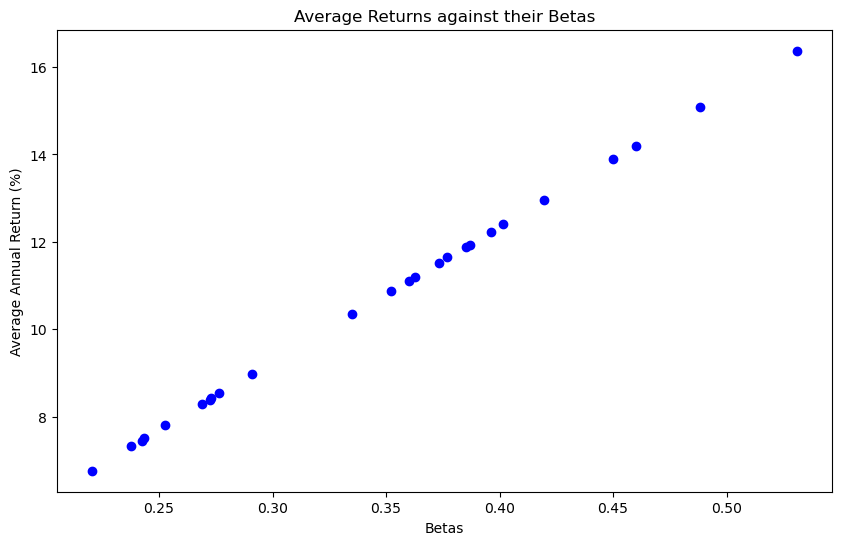

In [729]:
print("\n-------------------------------------------------------------------------------------------------\n")
betas_df, returns_df = betas_regressions_part_c(s2_return, new_market_proxy_df)
print("\n-------------------------------------------------------------------------------------------------\n")
plt.figure(figsize=(10,6))
plt.scatter(betas_df, returns_df * 12, color="blue")
plt.xlabel("Betas")
plt.ylabel("Average Annual Return (%)")
plt.title("Average Returns against their Betas")
plt.show()

We can confidently reject the null hypothesis that $\gamma_0$ = 0 and $\gamma_M$ = 0, due to the incredibly high t-statitistics for both coefficients. This is in line with Roll's critique of the CAPM, as Roll suggested that if the true market portfolio was known, than any efficient portfolio would perfectly explain returns. Hence, in that case, a perfect relationship between Betas and Returns will be possible, and that is seen from our graph here which suggests a practically perfect 1:1 relationship of betas to returns, and an R-statistic of 1. Thus, Roll would argue that we cannot definitively claim that the CAPM holds. Instead, your results reflect the explanatory power of the proxy market index you are using, but they don't confirm the CAPM's theoretical predictions for the true market portfolio. 

So, in conclusion, our market proxy seems like a good predictor, but it does not validate the CAPM model.

#### 3) Repeat parts c) and d) by splitting the data into a weights-calculation half and estimating-returns half.

In [730]:
diff_data = []
same_data = []

for index, row in s2_return.iterrows():
    if int(index.year) % 2 == 0:
        if int(index.month) % 2 == 0:
            same_data.append(row)
        else:
            diff_data.append(row)
    else:
        if int(index.month) % 2 == 0:
            diff_data.append(row)
        else:
            same_data.append(row)
sample_one = pd.DataFrame(diff_data)
sample_two = pd.DataFrame(same_data)

In [731]:
# ones matrices
ones_ = np.transpose([1]*len(sample_one.columns))
ones_T = np.transpose(ones_)

#sample 1 for weights and sample 2 for returns
return_cov_matrix_sample_one = np.linalg.inv(sample_one.cov())
R_1 = sample_one.mean()
numerator_one = return_cov_matrix_sample_one @ (R_1 - rf * ones_)
denominator_one = ones_T @ return_cov_matrix_sample_one @ (R_1 - rf * ones_)
weights_one = numerator_one / denominator_one
new_returns_one = sample_two @ weights_one

#sample 2 for weights and sample 1 for returns
return_cov_matrix_sample_two = np.linalg.inv(sample_two.cov())
R_2 = sample_two.mean()
numerator_two = return_cov_matrix_sample_two @ (R_2 - rf * ones_)
denominator_two = ones_T @ return_cov_matrix_sample_two @ (R_2 - rf * ones_)
weights_two = numerator_two / denominator_two
new_returns_two = sample_one @ weights_two

#combine the two datasets
new_returns_split = pd.concat([new_returns_one, new_returns_two])
new_market_proxy_df_split = market_proxy_df.copy()
new_market_proxy_df_split['Mkt-RF'] = new_returns_split - market_proxy_df['RF']


-------------------------------------------------------------------------------------------------

Cross-Sectional Regression Results:
Gamma 0 (Intercept): 0.06000853744741912, SE: 0.030267052916589664, t-stat: -7.204096239321597
Gamma M (Slope): 3.1074817255781446, SE: 0.10967484440464467, t-stat: 28.333586816983388

-------------------------------------------------------------------------------------------------



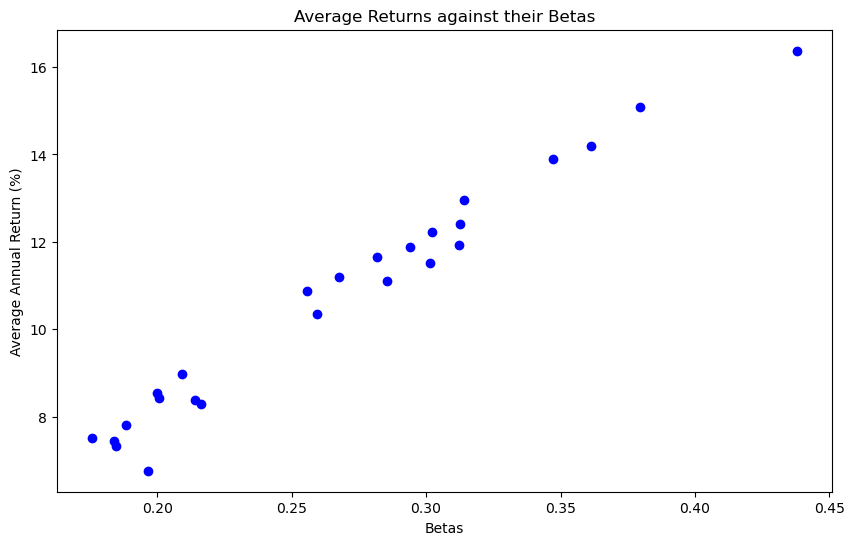

In [732]:
print("\n-------------------------------------------------------------------------------------------------\n")
betas_split, returns_split = betas_regressions_part_c(s2_return, new_market_proxy_df_split)
print("\n-------------------------------------------------------------------------------------------------\n")
plt.figure(figsize=(10,6))
plt.scatter(betas_split, returns_split * 12, color="blue")
plt.xlabel("Betas")
plt.ylabel("Average Annual Return (%)")
plt.title("Average Returns against their Betas")
plt.show()

We can confidently reject the null hypothesis that $\gamma_0$ = 0 and $\gamma_M$ = 0, due to the high t-statitistics for both coefficients.

#### 4)	How are the results different between 2) and 3) and why?  How does the difference in results between 2) and 3) showcase the Roll (1977) critique?

Both parts (2) and (3) show very very strong linear relationships between beta and average returns. Part (2) used the tangency portfolio of our original returns (craeting a perfect market proxy for our returns), and part (3) split the data in a clever way, which still created quite obviously a very strong market proxy for our specific returns, yet not nearly quite as strong. 

This showcases Roll's critique that the CAPM is very strongly reliant on the market proxy (mean-variance efficient portfolio), and is incredibly sensitive to any very slight changes in the portfolio, as seen in the remarkable differences between part c) and d) due to small altercations in the tangency portfolio calculations.  